In [1]:
import sys
import h5py
import random
import numpy as np
import imageio
import torch
import cv2
from torch import nn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

import albumentations as albu
from albumentations import pytorch as AT


import utils
from models import Generator, Discriminator
from wgan import GoodGenerator, GoodDiscriminator, kaiming_init


In [10]:
dataset_path = 'LLD-icon-sharp.hdf5'

hdf5_file = h5py.File(dataset_path, 'r')
images, labels = (hdf5_file['data'], hdf5_file['labels/resnet/rc_128'])


cleaned_dataset = np.load("cleaned_dataset.npy")

#params section
batch_size = 256
num_workers = 0
img_size = (32, 32, 1)
img_size_2 = (64, 64, 3)
generator = Generator(img_size, latent_dim=128, dim=32)
#generator = GoodGenerator(dim=32, latent_dim = 128,  output_dim=3*32*32)
discriminator = Discriminator(img_size=img_size, dim=32)
lr = 1e-4
betas = (0.5, .99)
weight_decay = 1e-04
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas )
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas, weight_decay = weight_decay )
G_sheduler = optim.lr_scheduler.StepLR(G_optimizer, step_size= 40, gamma=0.8)
D_sheduler = optim.lr_scheduler.StepLR(D_optimizer, step_size= 40, gamma=0.8)
epochs = 50



In [11]:
import pickle

with open('clusters.pickle', 'rb') as handle:
    clusters = pickle.load(handle)


In [12]:
test_dataset = np.vstack([clusters["array_70"],clusters["array_58"]])
test_dataset = np.vstack([test_dataset,clusters["array_65"]])
test_dataset = np.vstack([test_dataset,clusters["array_79"]])
test_dataset = np.vstack([test_dataset,clusters["array_91"]])

In [13]:
test_dataset.shape

(8157, 32, 32, 3)

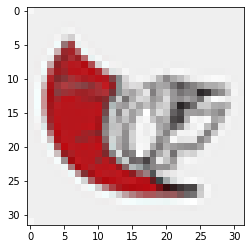

In [14]:
plt.imshow(test_dataset[18])

In [15]:
class IconsDataset(Dataset):
    def __init__(self, h5py_dataset, transforms = None):
        self.dataset = h5py_dataset
        self.transforms = transforms
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img = self.dataset[idx].transpose(1,2,0)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if self.transforms:
            sample = self.transforms(image=img)
            image = sample['image']
        
        return image.reshape(-1, 32, 32)
     

In [16]:
transforms = albu.Compose([ 
    #albu.Resize(32 ,32),
    #albu.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
    albu.Normalize((0.5), (0.5)),
                           AT.ToTensor(),
                          
                          ])

trainset = IconsDataset(images, transforms=transforms)
trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

In [17]:
next(iter(trainloader)).shape

torch.Size([256, 1, 32, 32])

In [18]:
class Trainer():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer, gen_sch, dis_sch,
                 gp_weight=10, critic_iterations=5, print_every=300,
                 use_cuda=False):
        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.G_sch = gen_sch
        self.D_sch = dis_sch
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data):
        """ """
        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate probabilities on real and generated data
        data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
        d_real = self.D(data)
        d_generated = self.D(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(data, generated_data)
        self.losses['GP'].append(gradient_penalty.data)

        # Create total loss and optimize
        self.D_opt.zero_grad()
        d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
        d_loss.backward()

        self.D_opt.step()

        # Record loss
        self.losses['D'].append(d_loss.data)

    def _generator_train_iteration(self, data):
        """ """
        self.G_opt.zero_grad()

        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate loss and optimize
        d_generated = self.D(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.G_opt.step()
        
        

        # Record loss
        self.losses['G'].append(g_loss.data)

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data)
            # Only update generator every |critic_iterations| iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)
                
            
                
            

            if i % self.print_every == 0:
                print("Iteration {}".format(i + 1))
                print("D: {}".format(self.losses['D'][-1]))
                print("GP: {}".format(self.losses['GP'][-1]))
                print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
                if self.num_steps > self.critic_iterations:
                    print("G: {}".format(self.losses['G'][-1]))

    def train(self, data_loader, epochs, save_training_gif=True):
        if save_training_gif:
            # Fix latents to see how image generation improves during training
            fixed_latents = Variable(self.G.sample_latent(64))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()
            training_progress_images = []

        for epoch in range(epochs):
            print("\nEpoch {}".format(epoch + 1))
            self._train_epoch(data_loader)
            self.G_sch.step()
            self.D_sch.step()

            if save_training_gif:
                # Generate batch of images and convert to grid
                img_grid = make_grid(self.G(fixed_latents).cpu().data)
                # Convert to numpy and transpose axes to fit imageio convention
                # i.e. (width, height, channels)
                img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
                # Add image grid to training progress
                training_progress_images.append(img_grid)
            if epoch == int(epochs/2):
                name = 'logo_model'
                torch.save(self.G.state_dict(), './gen_' + name + '.pt')
                torch.save(self.D.state_dict(), './dis_' + name + '.pt')
                
                

        if save_training_gif:
            imageio.mimsave('./training_{}_epochs.gif'.format(epochs),
                            training_progress_images)

    def sample_generator(self, num_samples):
        latent_samples = Variable(self.G.sample_latent(num_samples))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

In [ ]:
kaiming_init(generator)
#utils.gaussian_intiailize(generator, 0.02)
kaiming_init(discriminator)
                  
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer, G_sheduler, D_sheduler,
                  use_cuda=torch.cuda.is_available())
trainer.train(trainloader, epochs, save_training_gif=True)


Epoch 1
Iteration 1
D: 9.520402908325195
GP: 9.521985054016113
Gradient norm: 0.024193990975618362
Iteration 301
D: 0.6268367171287537
GP: 1.5061066150665283
Gradient norm: 0.7462074756622314
G: -0.05482346564531326
Iteration 601
D: -0.16717314720153809
GP: 0.7371512651443481
Gradient norm: 0.8396009206771851
G: -0.06128846853971481

Epoch 2
Iteration 1
D: -0.5464252233505249
GP: 0.4133366048336029
Gradient norm: 0.941683828830719
G: -0.013287665322422981
Iteration 301
D: -0.8214536905288696
GP: 0.13444332778453827
Gradient norm: 0.9992259740829468
G: -0.02859351597726345
Iteration 601
D: -0.883704423904419
GP: 0.07338617742061615
Gradient norm: 1.0308853387832642
G: -0.017944445833563805

Epoch 3
Iteration 1
D: -0.8754560947418213
GP: 0.0719267874956131
Gradient norm: 1.0476698875427246
G: -0.013402239419519901
Iteration 301
D: -0.9137744307518005
GP: 0.049461908638477325
Gradient norm: 1.0262281894683838
G: -0.005049615167081356
Iteration 601
D: -0.8859264254570007
GP: 0.06581383943

In [29]:
name = 'logo_model'
torch.save(trainer.G.state_dict(), './gen_' + name + '.pt')
torch.save(trainer.D.state_dict(), './dis_' + name + '.pt')

In [30]:
weight_path = "200ep_gray/gen_logo_model.pt"
netG = Generator(img_size, latent_dim=100, dim=16)
netG.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [60]:
netG.eval()
netG.cuda()

# Get latent vector Z from unit normal distribution.
noise = torch.randn(1, 100, device="cuda")

# Turn off gradient calculation to speed up the process.
with torch.no_grad():
	# Get generated image from the noise vector using
	# the trained generator.
    generated_img = netG(noise).detach().cpu()
generated_img.shape

torch.Size([1, 1, 32, 32])

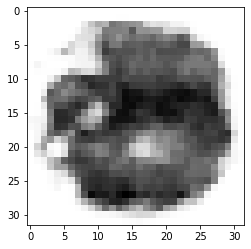

In [61]:
plt.imshow(generated_img[0].cpu().detach().numpy().squeeze(), cmap="gray")